In [1]:
pip install antropy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyedflib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

In [6]:
import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [8]:
WINDOW_STEP = 256

files = glob.glob('D:\Major_Project\project\dataset\chb02\*.edf')

seizure_period_foreach_file = [
    (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (1720, 1810),
    (327, 420),
    (1862, 1963),
    (130, 212),
    (2972, 3053),
    (362, 414),
    (731, 796),
    (432, 501),
    (2162, 2214),
    (7804, 7853),
    (1679, 1781),
    (3782, 3898),
    (417, 532),
    (1086, 1196),
    (2317, 2413),
    (2451, 2571),
    (2348, 2465),
    (327, 347),
    (6211, 6231),
    (12500, 12516),
    (10833, 10845),
    (506, 519),
    (7799, 7811),
    (9387, 9403),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2670, 2841),
    (2856, 3046),
    (2988, 3122),
    (2417, 2577),
    (2083, 2347),
    (12231, 12295),
    (2951, 3030),
    (9196, 9267),
    (5299, 5361),
    (6313, 6348),
    (6888, 6958),
    (2382, 2447),
    (3021, 3079),
    (3801, 3877),
    (4618, 4707),
    (1383, 1437),
]

seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end) 
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()
        
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        
        buffers = np.zeros((2, edf_reader.getNSamples()[0]))
        
        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)
        
        array_buffer = np.array(buffers)
        signals.append(array_buffer)

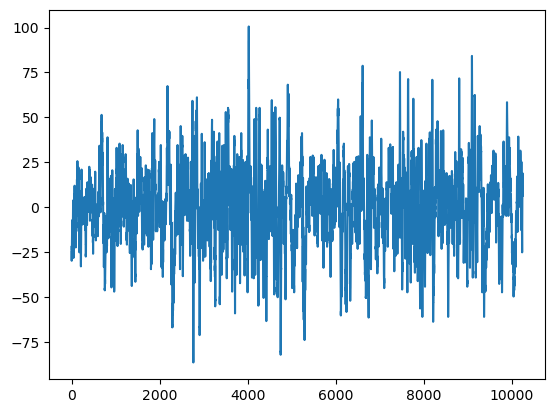

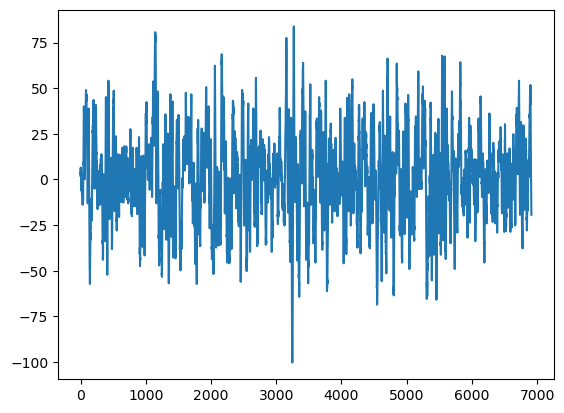

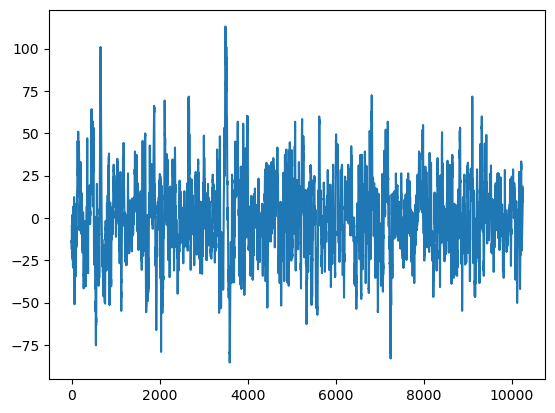

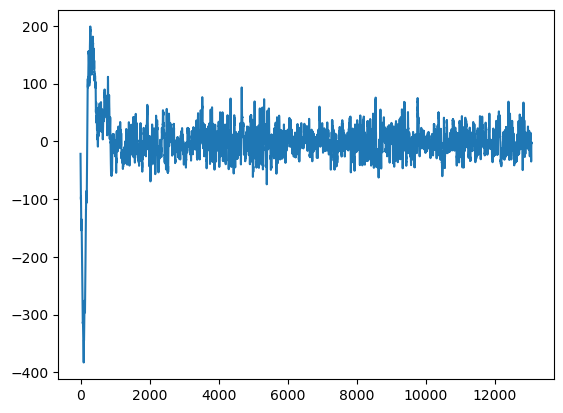

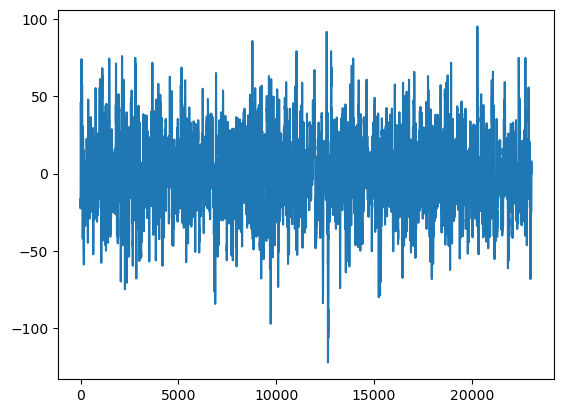

In [9]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

In [10]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals, 
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(520, 2, 1280)

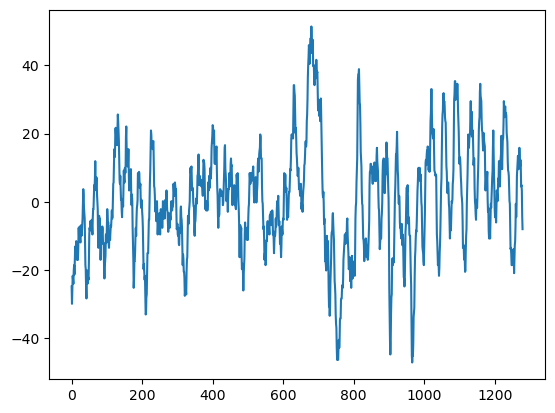

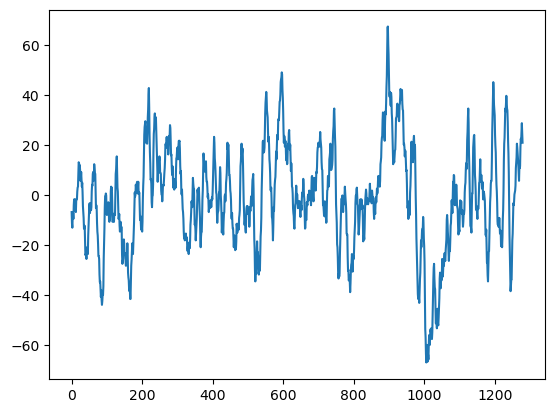

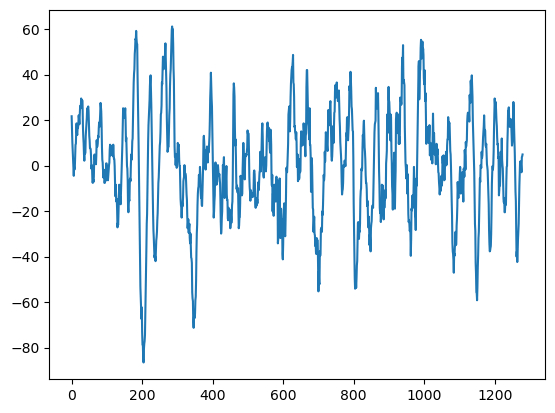

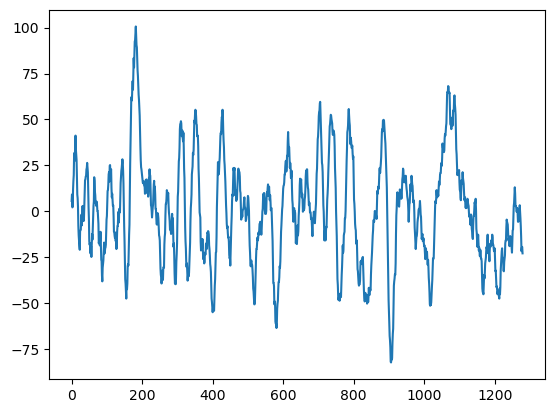

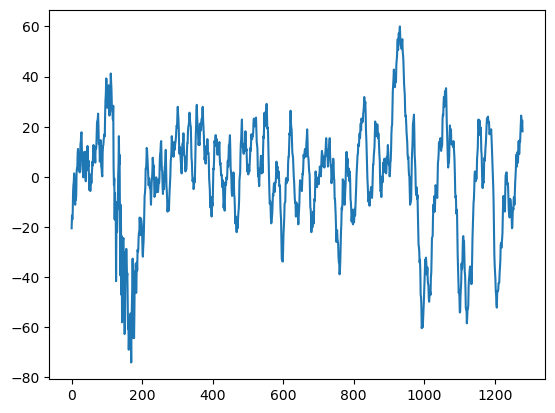

In [11]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

In [13]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[i][0]))
        high_range = int(0.95*len(signals[i][0]))
        signals[i] = signals[i][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

In [15]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

In [16]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals, 
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(8704, 2, 1280)

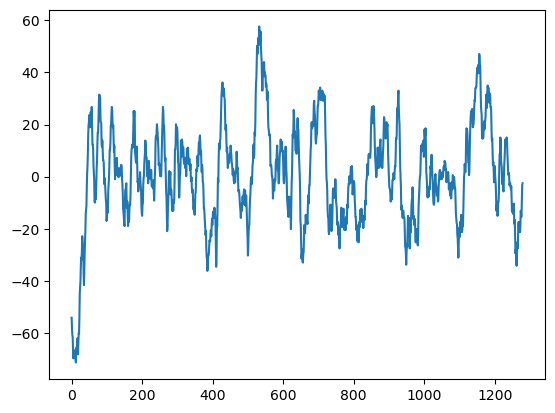

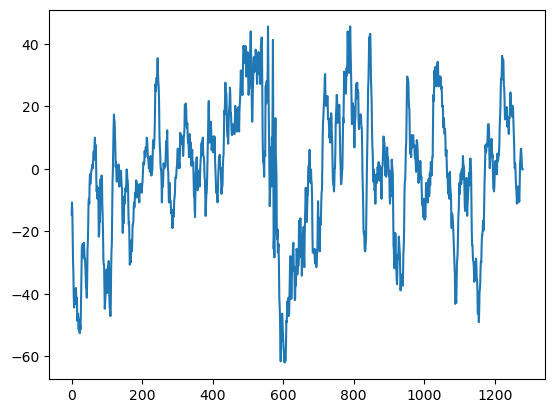

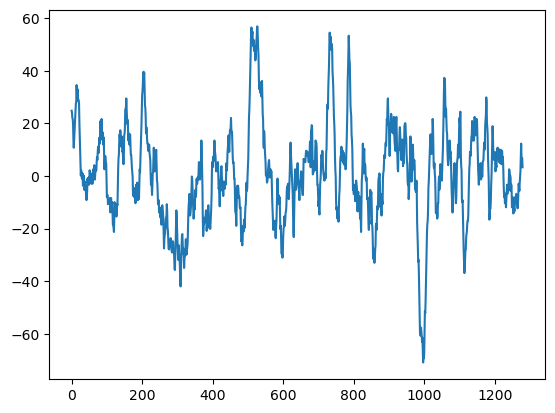

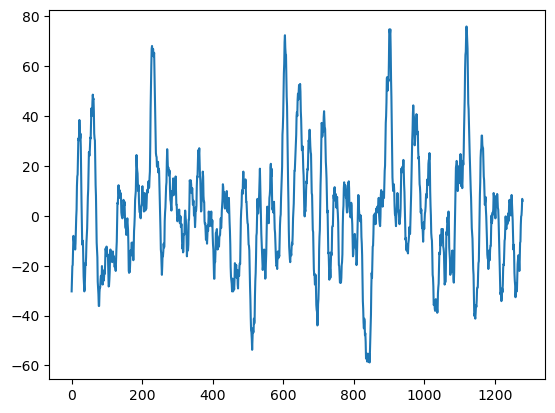

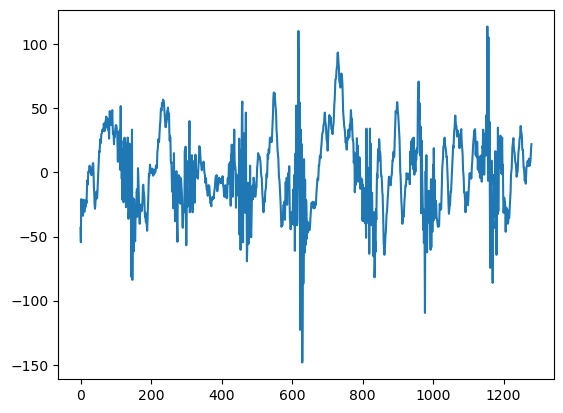

In [17]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

In [18]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [19]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(9224, 2, 1280) (9224,)


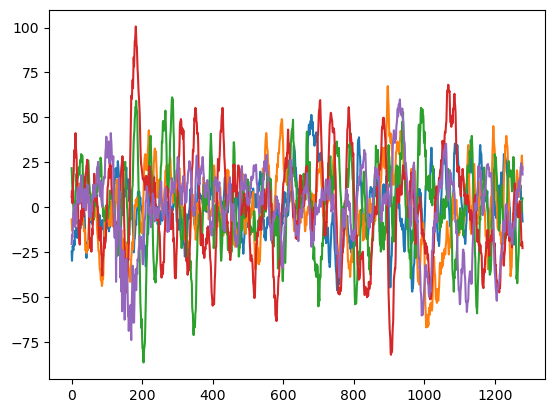

In [20]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()

In [21]:
def func_var(data):
    return np.var(data, axis=2)

def func_std(data):
    return np.std(data, axis=2)

def func_mean(data):
    return np.mean(data, axis=2)

def func_fft(data):
    return np.fft.fft(data, axis=2)

def func_fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def func_fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def func_fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def func_fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def func_fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def func_fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def func_power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def func_power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def func_complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def func_zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

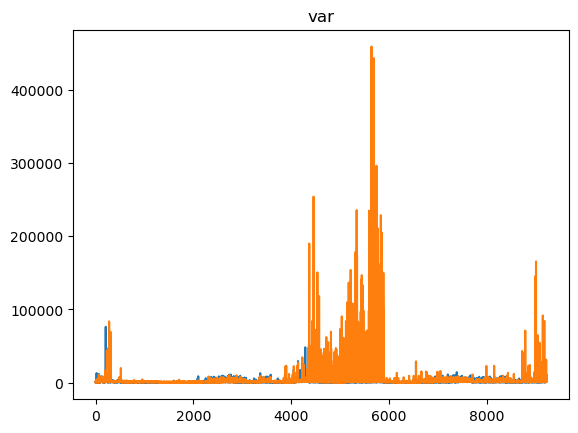

In [22]:
var = func_var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

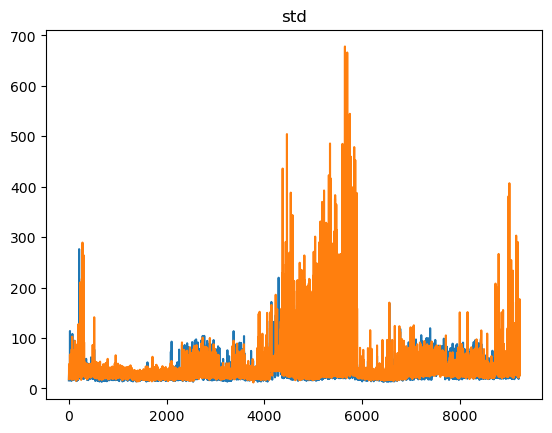

In [23]:
std = func_std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

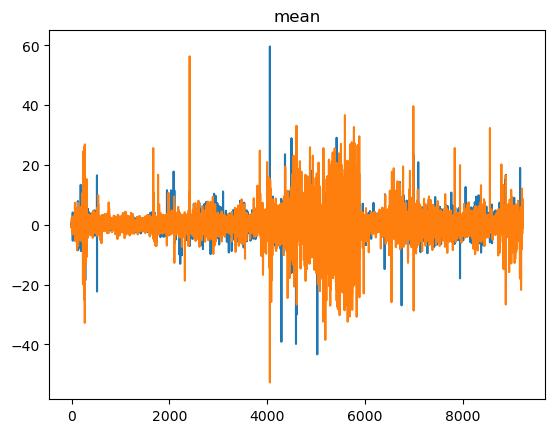

In [24]:
mean = func_mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()

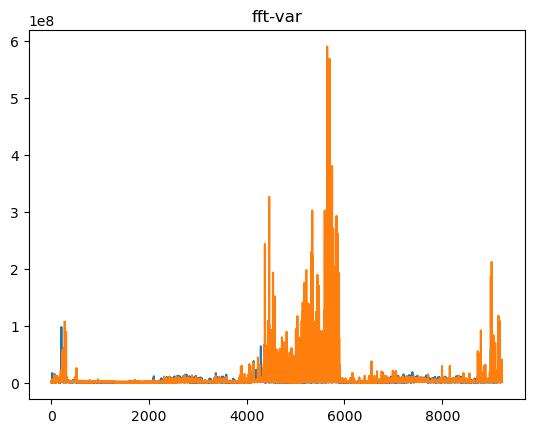

In [25]:
fft_var = func_fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()

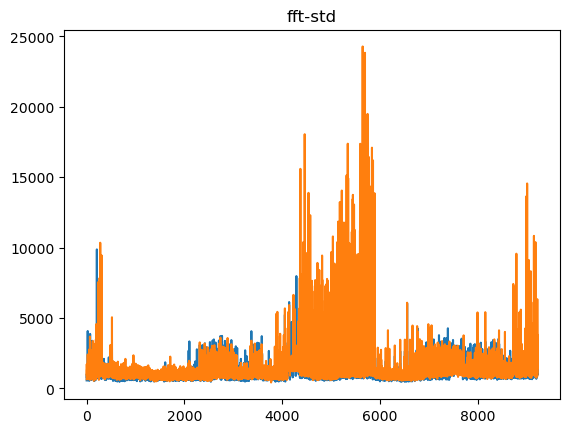

In [26]:
fft_std = func_fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

C:\Users\vraks\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


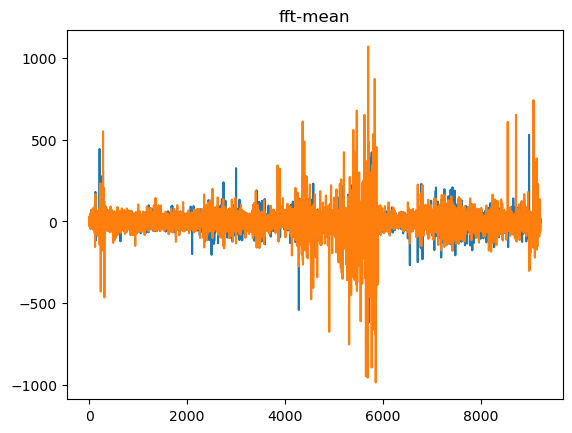

In [27]:
fft_mean = func_fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

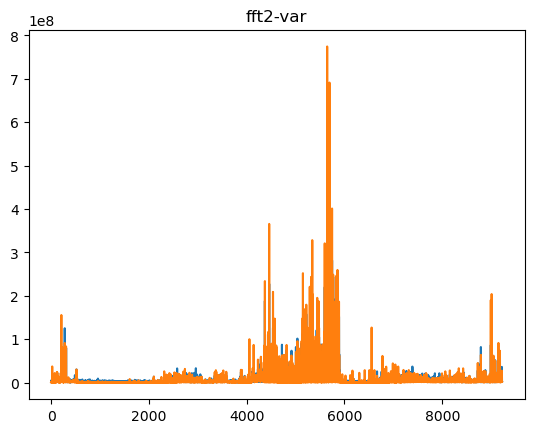

In [28]:
fft2_var = func_fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

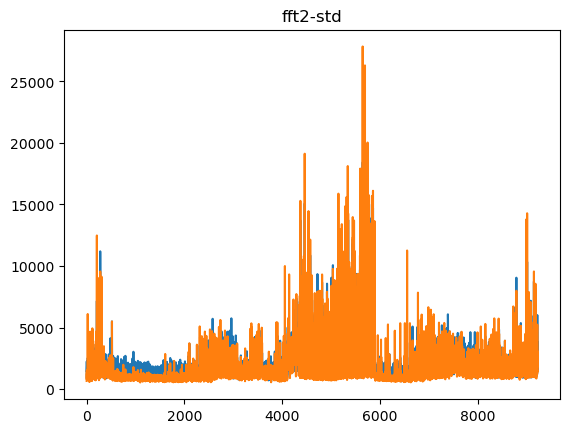

In [29]:
fft2_std = func_fft2_std(final_signals)

plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()


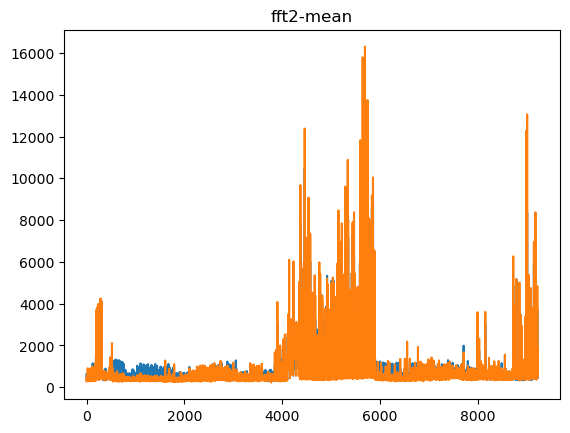

In [30]:
fft2_mean = func_fft2_mean(final_signals)

plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()

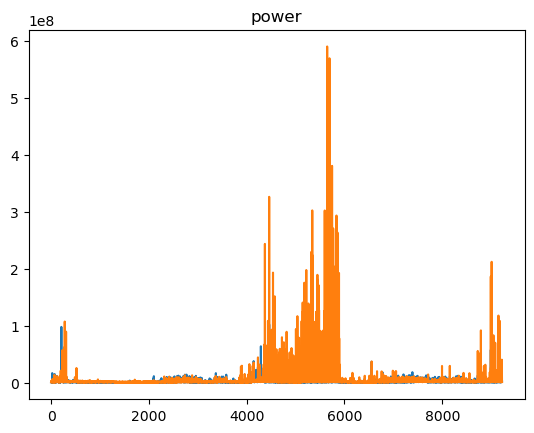

In [31]:
power = func_power(final_signals)

plt.title('power')
plt.plot(power)
plt.show()

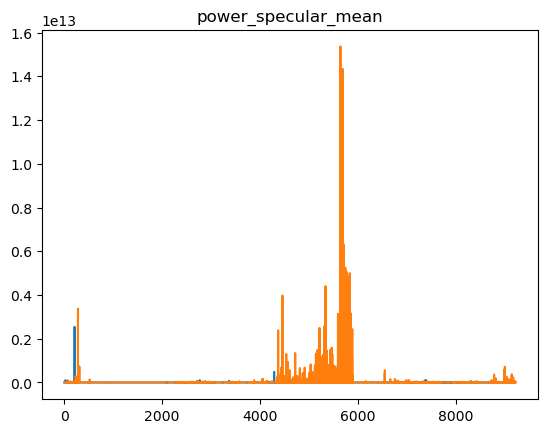

In [32]:
power_specular_mean = func_power_specular_mean(final_signals)

plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

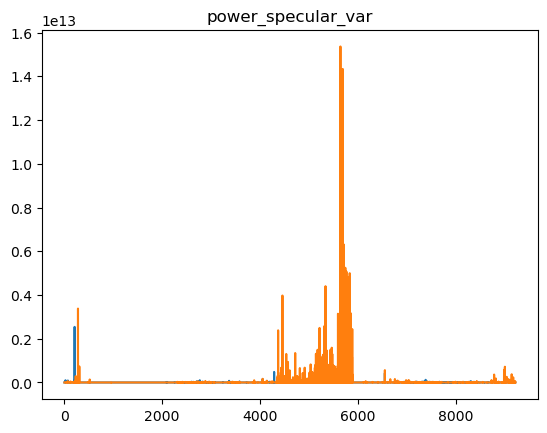

In [33]:
power_specular_var = func_power_specular_var(final_signals)

plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

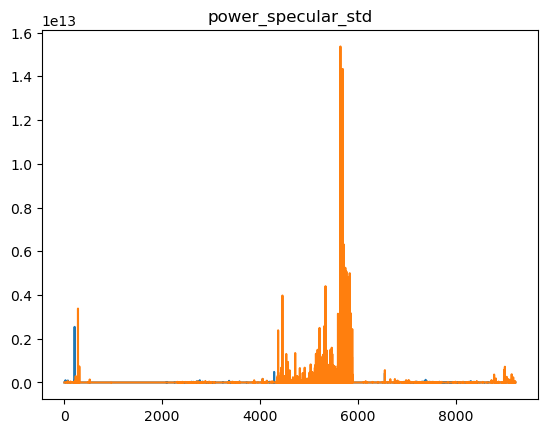

In [34]:
power_specular_std = func_power_specular_std(final_signals)

plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()


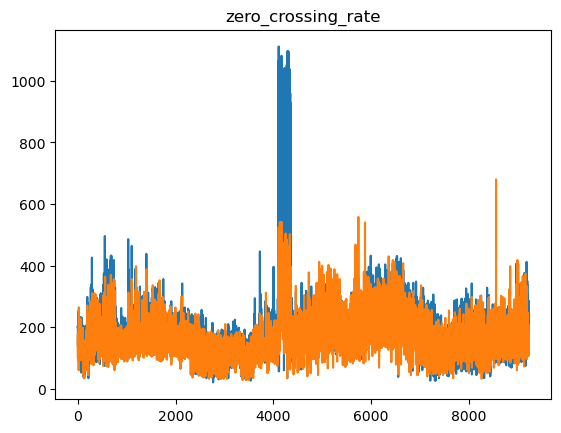

In [35]:
zero_crossing_rate = func_zero_crossing_rate(final_signals)

plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

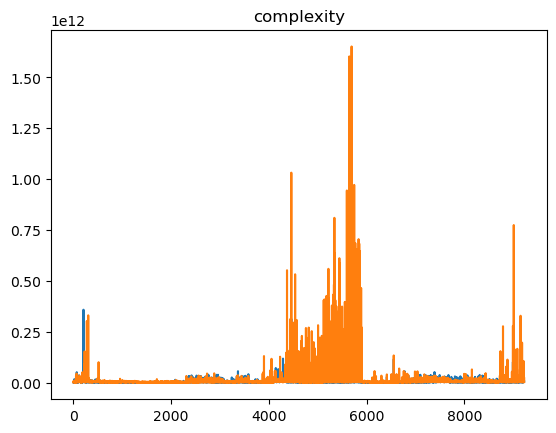

In [36]:
complexity = func_complexity(final_signals)

plt.title('complexity')
plt.plot(complexity)
plt.show()

In [37]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(9224, 28)

95.8069376693767
[[1730    0]
 [ 115    0]]


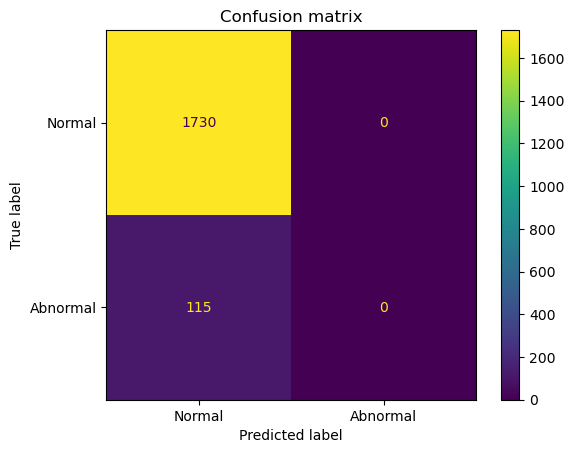

In [42]:
import pickle
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

pickle.dump(rf, open('randomforestmodel.pkl', 'wb'))

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

cm = confusion_matrix(y_test, y_prediction)

display = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Abnormal'])
display.plot()
display.ax_.set_title('Confusion matrix')
plt.show()

In [43]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [44]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer
sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1276, 256)         2816      
                                                                 
 max_pooling1d (MaxPooling1  (None, 638, 256)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 638, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 634, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 317, 128)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 317, 128)         

In [45]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_flat = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])
X_test_flat = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

X_train_resampled = X_train_resampled.reshape(-1, x_train.shape[1], x_train.shape[2])



In [46]:
sequential.fit(X_train_resampled, y_train_categorical, epochs=10, shuffle=True, verbose=2)
sequential.save('cnn_model.h5')

Epoch 1/10


231/231 - 82s - loss: 0.4486 - accuracy: 0.9383 - 82s/epoch - 357ms/step
Epoch 2/10
231/231 - 78s - loss: 0.2886 - accuracy: 0.9432 - 78s/epoch - 339ms/step
Epoch 3/10
231/231 - 78s - loss: 0.2416 - accuracy: 0.9448 - 78s/epoch - 337ms/step
Epoch 4/10
231/231 - 78s - loss: 0.2278 - accuracy: 0.9446 - 78s/epoch - 338ms/step
Epoch 5/10
231/231 - 79s - loss: 0.2217 - accuracy: 0.9448 - 79s/epoch - 340ms/step
Epoch 6/10
231/231 - 78s - loss: 0.2180 - accuracy: 0.9453 - 78s/epoch - 339ms/step
Epoch 7/10
231/231 - 79s - loss: 0.2169 - accuracy: 0.9451 - 79s/epoch - 343ms/step
Epoch 8/10
231/231 - 82s - loss: 0.2158 - accuracy: 0.9453 - 82s/epoch - 355ms/step
Epoch 9/10
231/231 - 78s - loss: 0.2223 - accuracy: 0.9448 - 78s/epoch - 339ms/step
Epoch 10/10
231/231 - 78s - loss: 0.2107 - accuracy: 0.9457 - 78s/epoch - 340ms/step


In [48]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

58/58 - 5s - loss: 0.2510 - accuracy: 0.9377 - 5s/epoch - 80ms/step
CNN - Loss: 0.25099748373031616, Accuracy: 94.27693964004517
